In [4]:
# 라이브러리 import 및 설정

import pandas as pd
import numpy as np
import pyodbc
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.multioutput import MultiOutputRegressor
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import optuna
import json
from datetime import datetime

# matplotlib을 위한 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")

라이브러리 import 완료


In [5]:
# DB 연결 및 데이터 로드

# 데이터베이스 설정
DB_CONFIG = {
    'driver': 'ODBC Driver 17 for SQL Server',
    'server': 'localhost',
    'database': 'real_data',
    'trusted_connection': 'yes'
}

# DB 연결
conn_str = (
    f"DRIVER={{{DB_CONFIG['driver']}}};"
    f"SERVER={DB_CONFIG['server']};"
    f"DATABASE={DB_CONFIG['database']};"
    f"Trusted_Connection={DB_CONFIG['trusted_connection']};"
)

conn = pyodbc.connect(conn_str)

query = "SELECT * FROM union_charge_divided_by_pattern"
df = pd.read_sql(query, conn)
conn.close()

print(f"데이터 로드 완료: {df.shape}")
print(f"\n컬럼 목록:")
print(df.columns.tolist())
df.head()

데이터 로드 완료: (8950, 85)

컬럼 목록:
['time', 'charge', 'charge_min', 'melting_min', 'oxidation_min', 'work_time', 'EAF_wattage', 'CaO_CFW', 'Dolomite_CFW', 'CaO_HP', 'FeMn_HP', 'FeSi_HP', 'SiMn_HP', 'Briquette_HP1', 'Briquette_HP2', 'melting_wattage', 'refining_wattage', 'wattage', 'lng_usage', 'coal_gsk', 'coal_stain', 'small_lump', 'Weight_Sum', 'tot_result1', 'consume_rate', 'tot_result4', 'scrap_domestic', 'scrap_iron_powder', 'scrap_heavy_a', 'scrap_heavy_b', 'scrap_container', 'scrap_h1', 'scrap_h2', 'scrap_russia', 'scrap_gs', 'master_speed_p3', 'master_location_p3', 'len_flow_p3', 'oxygen_bu_p3', 'oxygen_len_p3', 'master_speed_p5', 'master_location_p5', 'len_flow_p5', 'oxygen_bu_p5', 'oxygen_len_p5', 'master_speed_p8', 'master_location_p8', 'len_flow_p8', 'oxygen_bu_p8', 'oxygen_len_p8', 'scrap_bal_go', 'len_tilting_height_p3', 'len_tilting_width_p3', 'len_tilting_height_p5', 'len_tilting_width_p5', 'len_tilting_height_p8', 'len_tilting_width_p8', 'power_factor_p3', 'set_voltage_p3',

,time,charge,charge_min,melting_min,oxidation_min,work_time,EAF_wattage,CaO_CFW,Dolomite_CFW,CaO_HP,...,consume_rate_tmp,precipitator_jig_p3,precipitator_gun_p3,precipitator_wind_p3,precipitator_jig_p5,precipitator_gun_p5,precipitator_wind_p5,precipitator_jig_p8,precipitator_gun_p8,precipitator_wind_p8
0,2022-01-02,2200008,2.0,30.0,5.0,43.0,8800.0,NaN,NaN,595.0,...,402.56,578.89,1908.22,100005.49,600.55,1925.73,106811.97,596.57,1859.70,104319.60
1,2022-01-03,2200031,2.0,30.0,6.0,44.0,29900.0,NaN,NaN,597.0,...,405.53,535.33,1909.54,103329.70,583.49,2034.77,99562.53,550.80,1953.49,102490.38
2,2022-01-03,2200036,2.0,30.0,5.0,43.0,25900.0,NaN,NaN,593.0,...,399.12,590.04,1984.08,102344.89,581.20,1866.93,99884.62,582.13,1862.99,103613.78
3,2022-01-04,2200074,2.0,28.0,12.0,48.0,35800.0,NaN,NaN,598.0,...,408.66,619.85,1968.78,99476.76,656.61,1992.45,97155.71,635.90,1863.52,100912.30
4,2022-01-06,2200097,2.0,30.0,8.0,46.0,18100.0,NaN,NaN,596.0,...,424.98,501.36,1890.76,109034.05,519.23,2032.69,107286.12,516.42,1768.69,107425.97


In [6]:
# time 컬럼 제거 (학습에 사용 안 함)
if 'time' in df.columns:
    df_processed = df.drop('time', axis=1)
else:
    df_processed = df.copy()

# 결측치(미투입)를 0으로 변환
df_processed = df_processed.fillna(0)

print(f"전처리 전: {df.shape}")
print(f"전처리 후: {df_processed.shape}")

# 결측치 현황 확인
null_counts = df_processed.isnull().sum().sort_values(ascending=False)
print(f"\n결측치 개수: {null_counts.sum()} (전부 0으로 채움 완료)")

전처리 전: (8950, 85)
전처리 후: (8950, 84)

결측치 개수: 0 (전부 0으로 채움 완료)


In [7]:
# 예측할 목표 변수 선택
TARGETS = ['tot_result1']

# 사용할 특성만 직접 선택
SELECTED_FEATURES = [
    #시간
    #'time',
    # 'charge',
    # 'charge_min',
    # 'melting_min',
    # 'oxidation_min',
    # 'work_time',
    
    
    #부원료
    # 'CaO_CFW',
    # 'Dolomite_CFW',
    'CaO_HP',
    'FeMn_HP',
    'FeSi_HP',
    'SiMn_HP',
    'Briquette_HP1',
    'Briquette_HP2',
    'precipitator_jig_p3',
    'precipitator_jig_p5',
    'precipitator_jig_p8',
    'precipitator_gun_p3',
    'precipitator_gun_p5',
    'precipitator_gun_p8',
    'precipitator_wind_p3',
    'precipitator_wind_p5',
    'precipitator_wind_p8',



    #전력량
    # 'melting_wattage',
    # 'refining_wattage',
    # 'wattage',
    # 'EAF_wattage',

    #마스터
    # 'master_speed_p3',
    'master_location_p3',
    # 'master_speed_p5',
    'master_location_p5',
    # 'master_speed_p8',
    'master_location_p8',

    #랜스
    # 'len_tilting_height',
    # 'len_tilting_width',
    # 'len_flow_p3',
    # 'len_flow_p5',
    # 'len_flow_p8',
    'oxygen_len_p3',
    'oxygen_len_p5',
    'oxygen_len_p8',
    'len_tilting_height_p3',
    'len_tilting_width_p3',
    'len_tilting_height_p5',
    'len_tilting_width_p5',
    'len_tilting_height_p8',
    'len_tilting_width_p8',

    #버너
    'oxygen_bu_p3',
    'oxygen_bu_p5',
    'oxygen_bu_p8',
    
    #스크랩
    'Weight_Sum',
    # 'tot_result1',
    # 'tot_result4',


    'lng_usage',
    'coal_gsk',
    'coal_stain',
    'small_lump',
    # 'power_factor',
    # 'real_voltage',
    # 'real_current',

    
    ]


#target들 중 하나라도 null인 행 제거
df_model = df_processed.dropna(subset=TARGETS)


# X, y 분리
X = df_model[SELECTED_FEATURES]
y = df_model[TARGETS]

print("=" * 60)
print(f"타겟 변수: {TARGETS}")
print(f"데이터 개수: {len(X)}")
print(f"사용할 특성 개수: {len(SELECTED_FEATURES)}")
print("=" * 60)


print(f"\n【타겟 변수 통계】")
if len(TARGETS) == 1:
    print(y.describe())
else:
    print(y.describe())

print(f"\n【사용할 특성 ({len(SELECTED_FEATURES)}개)】")
for i, feat in enumerate(SELECTED_FEATURES, 1):
    null_count = X[feat].isnull().sum()
    null_pct = (null_count / len(X)) * 100
    print(f"{i:2d}. {feat:25s} (결측: {null_count:4d}건, {null_pct:5.1f}%)")

타겟 변수: ['wattage_tmp']
데이터 개수: 8950
사용할 특성 개수: 35

【타겟 변수 통계】
        wattage_tmp
count   8950.000000
mean   44923.262570
std     1178.270916
min    40800.000000
25%    44100.000000
50%    44900.000000
75%    45600.000000
max    53000.000000

【사용할 특성 (35개)】
 1. CaO_HP                    (결측:    0건,   0.0%)
 2. FeMn_HP                   (결측:    0건,   0.0%)
 3. FeSi_HP                   (결측:    0건,   0.0%)
 4. SiMn_HP                   (결측:    0건,   0.0%)
 5. Briquette_HP1             (결측:    0건,   0.0%)
 6. Briquette_HP2             (결측:    0건,   0.0%)
 7. precipitator_jig_p3       (결측:    0건,   0.0%)
 8. precipitator_jig_p5       (결측:    0건,   0.0%)
 9. precipitator_jig_p8       (결측:    0건,   0.0%)
10. precipitator_gun_p3       (결측:    0건,   0.0%)
11. precipitator_gun_p5       (결측:    0건,   0.0%)
12. precipitator_gun_p8       (결측:    0건,   0.0%)
13. precipitator_wind_p3      (결측:    0건,   0.0%)
14. precipitator_wind_p5      (결측:    0건,   0.0%)
15. precipitator_wind_p8      (결측:    0건, 

In [8]:
# 데이터 분할 (학습, 테스트 각각 0.8, 0.2)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42
)

print(f"Train set: {X_train.shape}")
print(f"Test set: {X_test.shape}")
print(f"\nTrain y 데이터 통계:")
print(y_train.describe())
print(f"\nTest y 데이터 통계:")
print(y_test.describe())

Train set: (7160, 35)
Test set: (1790, 35)

Train y 데이터 통계:
        wattage_tmp
count   7160.000000
mean   44911.075419
std     1172.837798
min    40800.000000
25%    44100.000000
50%    44900.000000
75%    45600.000000
max    53000.000000

Test y 데이터 통계:
        wattage_tmp
count   1790.000000
mean   44972.011173
std     1198.850707
min    41600.000000
25%    44100.000000
50%    44900.000000
75%    45700.000000
max    51000.000000


n=2  BIC: 618287.0  AIC: 617317.4
n=3  BIC: 598187.9  AIC: 596730.2
n=4  BIC: 594076.8  AIC: 592130.8
n=5  BIC: 513537.7  AIC: 511103.5
n=6  BIC: 494816.0  AIC: 491893.5
n=7  BIC: 482138.6  AIC: 478728.0

Best n by BIC: 7
Best n by AIC: 7


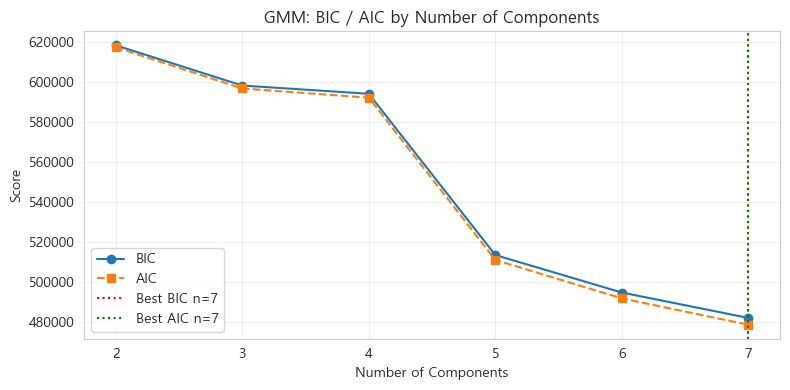

In [9]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

# --- globals 초기화 ---
if "X_train" not in globals():
    X_train = X_test = y_train = y_test = None
if "X_train_scaled" not in globals():
    X_train_scaled = X_test_scaled = None
if "scaler" not in globals():
    scaler = None

# --- ensure_train_test_scaled 정의 ---
def ensure_train_test_scaled(test_size=0.2, random_state=42):
    global X_train, X_test, y_train, y_test, X_train_scaled, X_test_scaled, scaler

    if "X" not in globals() or "y" not in globals():
        raise RuntimeError("Run the data prep cells (target/features) before this cell.")

    if X_train is None or X_test is None or y_train is None or y_test is None:
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=test_size, random_state=random_state
        )

    if scaler is None or X_train_scaled is None or X_test_scaled is None:
        scaler = StandardScaler()
        X_train_scaled = pd.DataFrame(
            scaler.fit_transform(X_train), index=X_train.index, columns=X_train.columns
        )
        X_test_scaled = pd.DataFrame(
            scaler.transform(X_test), index=X_test.index, columns=X_test.columns
        )

# Ensure train/test split + scaling exist
ensure_train_test_scaled(test_size=0.2, random_state=42)

# --- speed mode ---
FAST_MODE = True  # True: faster / False: full

# GMM configuration
GMM_KWARGS = {
    "covariance_type": "diag",
    "reg_covar": 1e-6,
    "n_init": 1 if FAST_MODE else 3,
}

# ===== BIC/AIC for reference (X only, no leakage) =====
N_RANGE = range(2, 6) if FAST_MODE else range(2, 8)
BIC_AIC_SAMPLE = 3000 if FAST_MODE else 8000  # None or int (use subset for speed)

X_train_arr = X_train_scaled.values
if BIC_AIC_SAMPLE is not None and len(X_train_arr) > BIC_AIC_SAMPLE:
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X_train_arr), size=BIC_AIC_SAMPLE, replace=False)
    X_bic = X_train_arr[idx]
else:
    X_bic = X_train_arr

n_range = N_RANGE  # keep compatibility with downstream cells
bic_scores = []
aic_scores = []

for n in n_range:
    gmm_test = GaussianMixture(n_components=n, random_state=42, **GMM_KWARGS)
    gmm_test.fit(X_bic)
    bic_scores.append(gmm_test.bic(X_bic))
    aic_scores.append(gmm_test.aic(X_bic))
    print(f"n={n}  BIC: {bic_scores[-1]:.1f}  AIC: {aic_scores[-1]:.1f}")

best_n_bic = list(n_range)[int(np.argmin(bic_scores))]
best_n_aic = list(n_range)[int(np.argmin(aic_scores))]

print()
print(f"Best n by BIC: {best_n_bic}")
print(f"Best n by AIC: {best_n_aic}")

# Visualize BIC/AIC (reference only)
fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(list(n_range), bic_scores, 'o-', label='BIC')
ax.plot(list(n_range), aic_scores, 's--', label='AIC')
ax.axvline(x=best_n_bic, color='red', linestyle=':', label=f'Best BIC n={best_n_bic}')
ax.axvline(x=best_n_aic, color='green', linestyle=':', label=f'Best AIC n={best_n_aic}')
ax.set_xlabel('Number of Components')
ax.set_ylabel('Score')
ax.set_title('GMM: BIC / AIC by Number of Components')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [10]:
# ===== Hyperparameter setup =====
USE_GPU = True
FAST_MODE = globals().get("FAST_MODE", True)

params = {
    "objective": "reg:squarederror",
    "random_state": 42,
    "tree_method": "hist",
    "device": "cuda" if USE_GPU else "cpu",
    "sampling_method": "gradient_based" if USE_GPU else "uniform",
    "max_bin": 128 if FAST_MODE else 256,
    "max_depth": 4,
    "learning_rate": 0.03,
    "n_estimators": 280 if FAST_MODE else 450,
    "subsample": 0.75,
    "colsample_bytree": 0.65,
    "min_child_weight": 14,
    "gamma": 10.0,
    "reg_alpha": 4.0,
    "reg_lambda": 18.0,
    "eval_metric": "rmse",
    "n_jobs": -1,
}

# ===== Select best_n by information criterion =====
criterion = "bic"  # "bic" or "aic"
if criterion == "bic":
    best_n = best_n_bic
elif criterion == "aic":
    best_n = best_n_aic
else:
    raise ValueError("criterion must be 'bic' or 'aic'")

print(f"Selected best_n by {criterion.upper()}: {best_n}")

# Use scaled features for GMM consistency
gmm = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
train_clusters = gmm.fit_predict(X_train_scaled.values)
test_clusters = gmm.predict(X_test_scaled.values)

print(f"Cluster count: {best_n}")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()} rows, Test {(test_clusters == c).sum()} rows")

# Train one global model first; cluster models only override where data is enough
global_model = xgb.XGBRegressor(**params)
global_model.fit(X_train, y_train.values.ravel(), verbose=False)

MIN_CLUSTER_SIZE = max(80, int(0.03 * len(X_train)))
print(f"MIN_CLUSTER_SIZE: {MIN_CLUSTER_SIZE}")

models = {}
for c in range(best_n):
    train_mask = train_clusters == c
    X_c = X_train[train_mask]
    y_c = y_train.values.ravel()[train_mask]

    if len(X_c) < MIN_CLUSTER_SIZE:
        print(f"[Cluster {c}] skipped (rows={len(X_c)})")
        continue

    model_c = xgb.XGBRegressor(**params)
    model_c.fit(X_c, y_c, verbose=False)
    models[c] = model_c
    print(f"[Cluster {c}] trained (rows={len(X_c)})")

print(f"\nTraining done. Cluster models: {len(models)}/{best_n}")



Selected best_n by BIC: 7

Validation metrics by n:
  n=2: R2=0.4812, SMAPE=1.42%
  n=3: R2=0.4887, SMAPE=1.41%
  n=4: R2=0.4696, SMAPE=1.43%
  n=5: R2=0.4767, SMAPE=1.43%
  n=6: R2=0.4770, SMAPE=1.42%
  n=7: R2=0.4767, SMAPE=1.43%
Selected best_n by R2->SMAPE: 3 (R2=0.4887, SMAPE=1.41%)
Info-criterion best_n: 7 | Validation-best n: 3
최적 클러스터 수: 7
  Cluster 0: Train 1159건, Test 278건
  Cluster 1: Train 1392건, Test 363건
  Cluster 2: Train 1522건, Test 407건
  Cluster 3: Train 1999건, Test 497건
  Cluster 4: Train 130건, Test 16건
  Cluster 5: Train 353건, Test 63건
  Cluster 6: Train 605건, Test 166건
[Cluster 0] 학습 완료 - 데이터: 1159건
[Cluster 1] 학습 완료 - 데이터: 1392건
[Cluster 2] 학습 완료 - 데이터: 1522건
[Cluster 3] 학습 완료 - 데이터: 1999건
[Cluster 4] 학습 완료 - 데이터: 130건
[Cluster 5] 학습 완료 - 데이터: 353건
[Cluster 6] 학습 완료 - 데이터: 605건

모델 학습 완료!


In [11]:
# Cluster prediction with global fallback
y_pred_train = global_model.predict(X_train)
y_pred_test = global_model.predict(X_test)

for c, model_c in models.items():
    train_mask = train_clusters == c
    test_mask = test_clusters == c

    if train_mask.sum() > 0:
        y_pred_train[train_mask] = model_c.predict(X_train[train_mask])
    if test_mask.sum() > 0:
        y_pred_test[test_mask] = model_c.predict(X_test[test_mask])

y_train_array = y_train.values.ravel()
y_test_array = y_test.values.ravel()

targets_to_evaluate = [(
    TARGETS[0],
    y_train_array,
    y_test_array,
    y_pred_train,
    y_pred_test,
)]

print("=" * 70)
print(f"Model metrics (GMM split, best_n={best_n}, overrides={len(models)})")
print("=" * 70)

for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    test_mape = np.mean(np.abs((y_te - y_pred_te) / (y_te + 1e-9))) * 100
    test_smape = 100 / len(y_te) * np.sum(
        2 * np.abs(y_pred_te - y_te) / (np.abs(y_te) + np.abs(y_pred_te) + 1e-9)
    )

    print(f"\n[{target_name}]")
    print(f"  Train RMSE: {train_rmse:.4f}  |  Train R2: {train_r2:.4f}")
    print(f"  Test RMSE:  {test_rmse:.4f}  |  Test R2:  {test_r2:.4f}")
    print(f"  Test MAE:   {test_mae:.4f}")
    print(f"  Test MAPE:  {test_mape:.2f}%")
    print(f"  Test SMAPE: {test_smape:.2f}%")

    overfitting = train_r2 - test_r2
    print(f"  Overfitting check (R2 gap): {overfitting:.4f}", end="")
    if overfitting > 0.1:
        print("  [warning]")
    else:
        print("  [ok]")



모델 성능 평가 (GMM 7그룹 분할 학습)

【wattage_tmp】
  Train RMSE: 290.9826  |  Train R²: 0.9384
  Test RMSE:  901.1589  |  Test R²:  0.4347
  Test MAE:   666.3578
  Test MAPE:  1.47%
  Test SMAPE: 1.48%
  과적합 체크 (R² 차이): 0.5038  ⚠️ 과적합 가능성


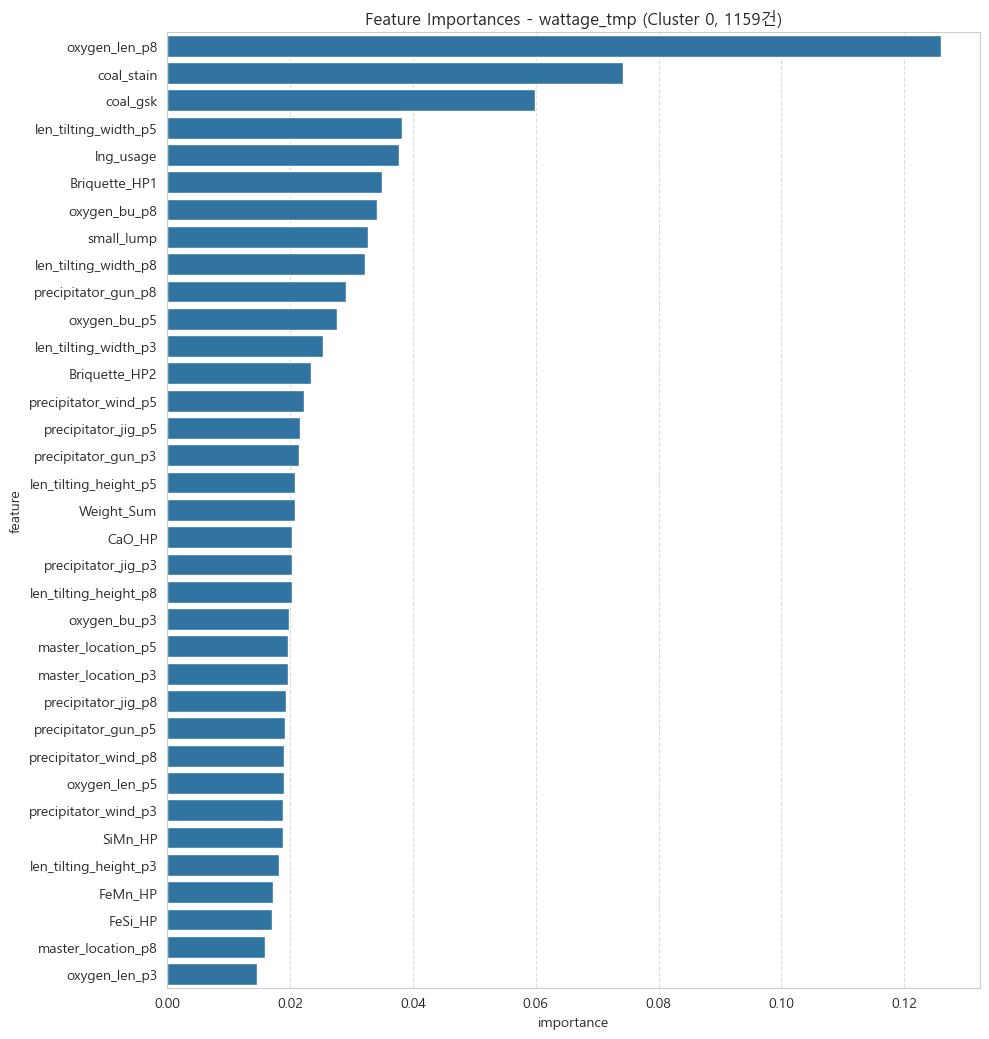


[Cluster 0 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.126041
33             coal_stain    0.074195
32               coal_gsk    0.059891
24   len_tilting_width_p5    0.038284
31              lng_usage    0.037795
4           Briquette_HP1    0.034999
29           oxygen_bu_p8    0.034108
34             small_lump    0.032735
26   len_tilting_width_p8    0.032116
11    precipitator_gun_p8    0.029056
28           oxygen_bu_p5    0.027713
22   len_tilting_width_p3    0.025438
5           Briquette_HP2    0.023332
13   precipitator_wind_p5    0.022202
7     precipitator_jig_p5    0.021581
9     precipitator_gun_p3    0.021495
23  len_tilting_height_p5    0.020841
30             Weight_Sum    0.020818
0                  CaO_HP    0.020372
6     precipitator_jig_p3    0.020347
25  len_tilting_height_p8    0.020331
27           oxygen_bu_p3    0.019744
16     master_location_p5    0.019712
15     master_location_p3    0.019673
8     precipitator_jig_p8  

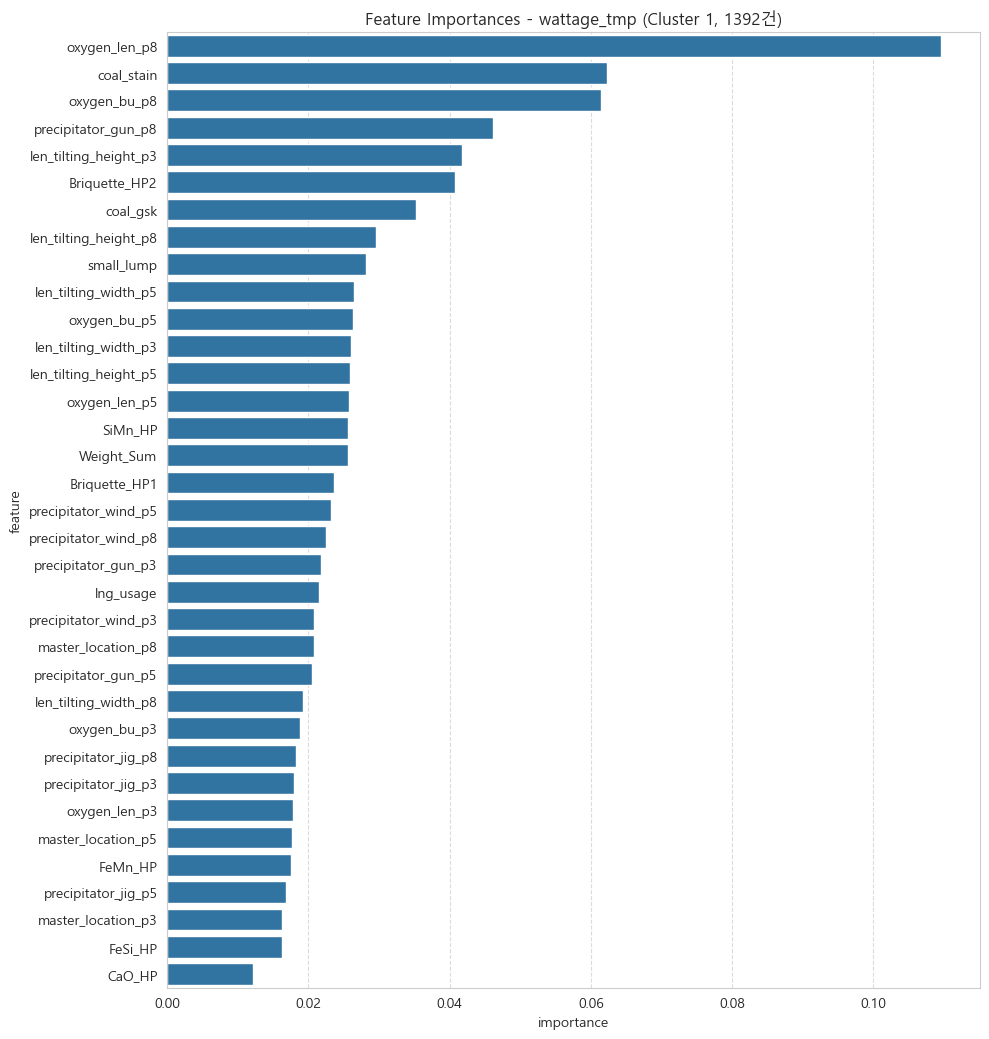


[Cluster 1 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.109645
33             coal_stain    0.062332
29           oxygen_bu_p8    0.061416
11    precipitator_gun_p8    0.046130
21  len_tilting_height_p3    0.041813
5           Briquette_HP2    0.040819
32               coal_gsk    0.035301
25  len_tilting_height_p8    0.029600
34             small_lump    0.028084
24   len_tilting_width_p5    0.026513
28           oxygen_bu_p5    0.026268
22   len_tilting_width_p3    0.025980
23  len_tilting_height_p5    0.025830
19          oxygen_len_p5    0.025726
3                 SiMn_HP    0.025596
30             Weight_Sum    0.025574
4           Briquette_HP1    0.023679
13   precipitator_wind_p5    0.023223
14   precipitator_wind_p8    0.022522
9     precipitator_gun_p3    0.021711
31              lng_usage    0.021518
12   precipitator_wind_p3    0.020778
17     master_location_p8    0.020722
10    precipitator_gun_p5    0.020470
26   len_tilting_width_p8  

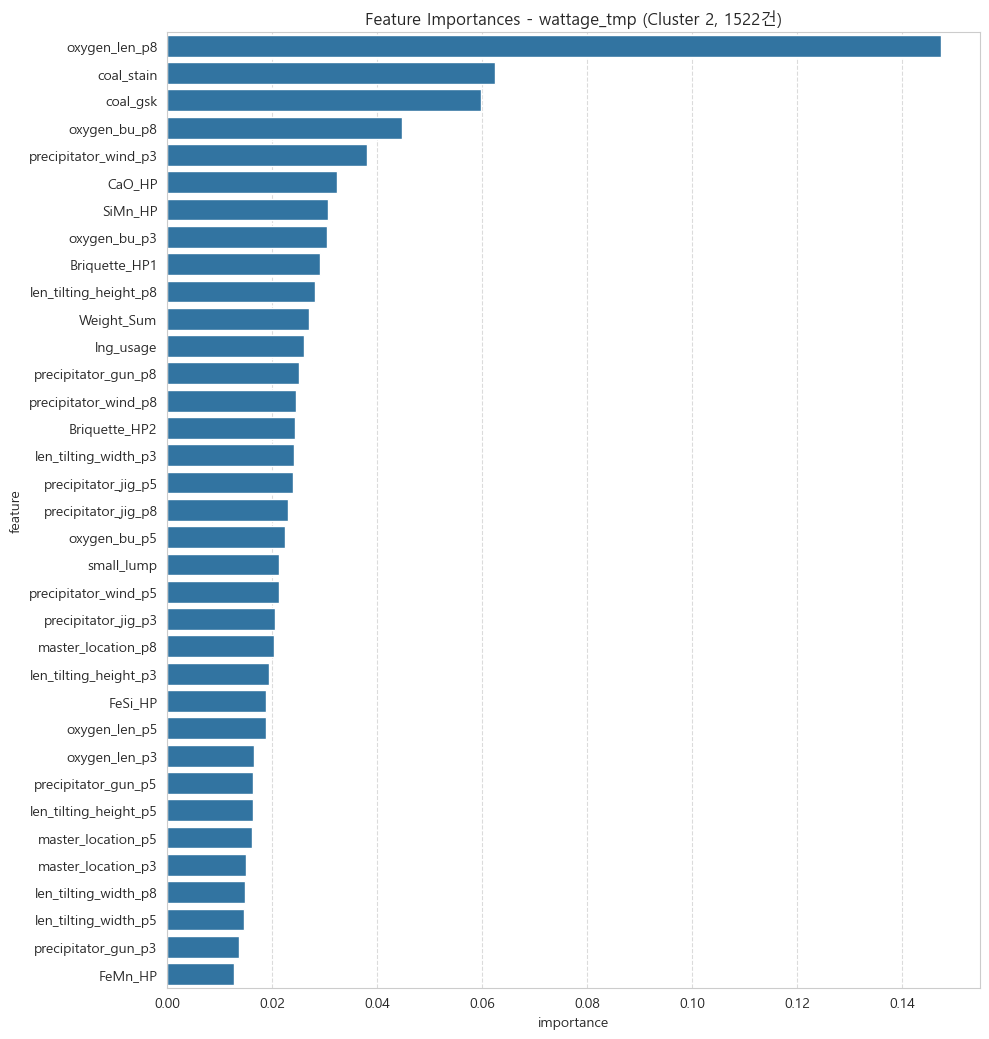


[Cluster 2 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.147510
33             coal_stain    0.062391
32               coal_gsk    0.059847
29           oxygen_bu_p8    0.044810
12   precipitator_wind_p3    0.038019
0                  CaO_HP    0.032381
3                 SiMn_HP    0.030541
27           oxygen_bu_p3    0.030447
4           Briquette_HP1    0.029100
25  len_tilting_height_p8    0.028209
30             Weight_Sum    0.026936
31              lng_usage    0.026131
11    precipitator_gun_p8    0.025161
14   precipitator_wind_p8    0.024592
5           Briquette_HP2    0.024317
22   len_tilting_width_p3    0.024162
7     precipitator_jig_p5    0.023992
8     precipitator_jig_p8    0.022950
28           oxygen_bu_p5    0.022358
34             small_lump    0.021216
13   precipitator_wind_p5    0.021206
6     precipitator_jig_p3    0.020448
17     master_location_p8    0.020271
21  len_tilting_height_p3    0.019448
2                 FeSi_HP  

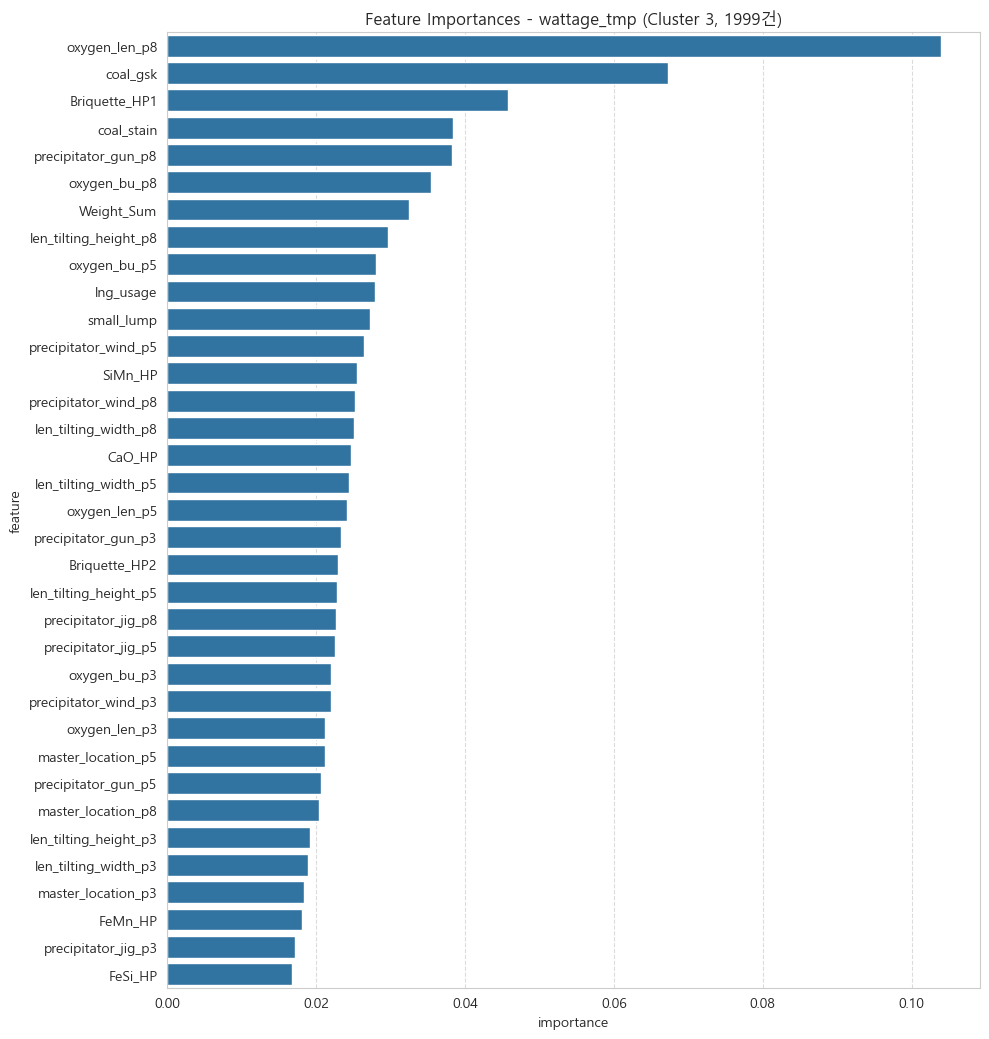


[Cluster 3 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.103978
32               coal_gsk    0.067225
4           Briquette_HP1    0.045717
33             coal_stain    0.038402
11    precipitator_gun_p8    0.038194
29           oxygen_bu_p8    0.035395
30             Weight_Sum    0.032449
25  len_tilting_height_p8    0.029648
28           oxygen_bu_p5    0.028065
31              lng_usage    0.027961
34             small_lump    0.027266
13   precipitator_wind_p5    0.026459
3                 SiMn_HP    0.025520
14   precipitator_wind_p8    0.025256
26   len_tilting_width_p8    0.025150
0                  CaO_HP    0.024623
24   len_tilting_width_p5    0.024434
19          oxygen_len_p5    0.024207
9     precipitator_gun_p3    0.023375
5           Briquette_HP2    0.022967
23  len_tilting_height_p5    0.022812
8     precipitator_jig_p8    0.022643
7     precipitator_jig_p5    0.022494
27           oxygen_bu_p3    0.022056
12   precipitator_wind_p3  

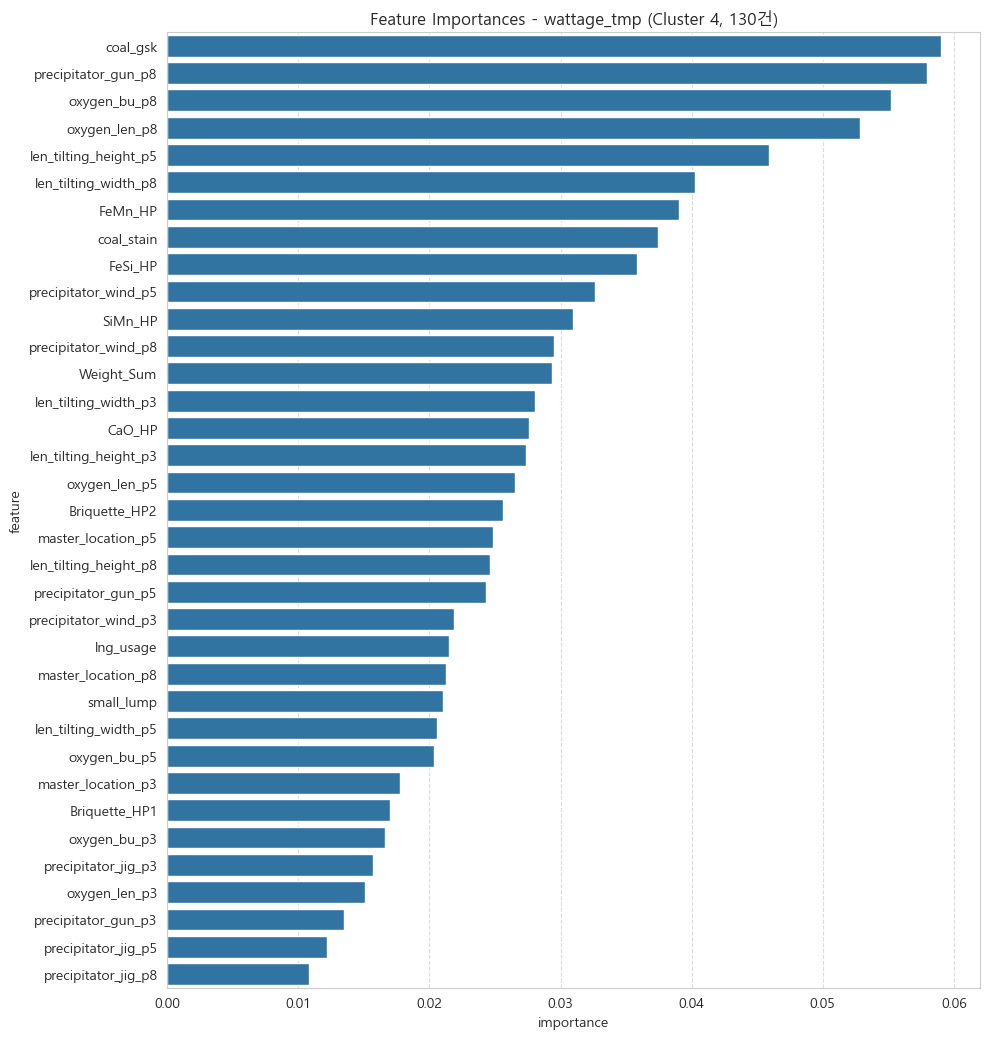


[Cluster 4 변수 중요도 순위]
                  feature  importance
32               coal_gsk    0.059040
11    precipitator_gun_p8    0.057956
29           oxygen_bu_p8    0.055214
20          oxygen_len_p8    0.052868
23  len_tilting_height_p5    0.045913
26   len_tilting_width_p8    0.040250
1                 FeMn_HP    0.039022
33             coal_stain    0.037442
2                 FeSi_HP    0.035814
13   precipitator_wind_p5    0.032616
3                 SiMn_HP    0.030949
14   precipitator_wind_p8    0.029484
30             Weight_Sum    0.029376
22   len_tilting_width_p3    0.028062
0                  CaO_HP    0.027576
21  len_tilting_height_p3    0.027395
19          oxygen_len_p5    0.026509
5           Briquette_HP2    0.025606
16     master_location_p5    0.024837
25  len_tilting_height_p8    0.024613
10    precipitator_gun_p5    0.024309
12   precipitator_wind_p3    0.021883
31              lng_usage    0.021485
17     master_location_p8    0.021239
34             small_lump  

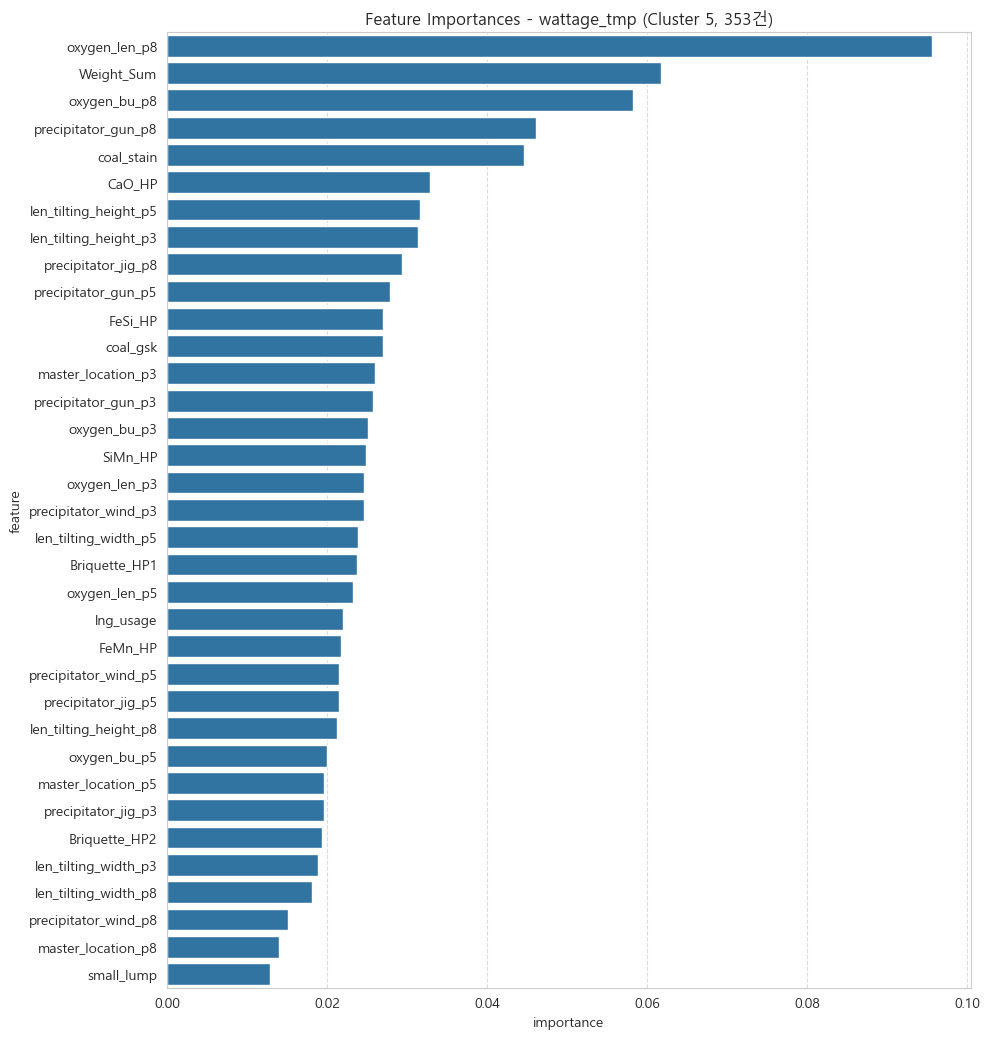


[Cluster 5 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.095683
30             Weight_Sum    0.061708
29           oxygen_bu_p8    0.058285
11    precipitator_gun_p8    0.046098
33             coal_stain    0.044552
0                  CaO_HP    0.032870
23  len_tilting_height_p5    0.031656
21  len_tilting_height_p3    0.031312
8     precipitator_jig_p8    0.029291
10    precipitator_gun_p5    0.027802
2                 FeSi_HP    0.027022
32               coal_gsk    0.026937
15     master_location_p3    0.025982
9     precipitator_gun_p3    0.025788
27           oxygen_bu_p3    0.025115
3                 SiMn_HP    0.024888
18          oxygen_len_p3    0.024633
12   precipitator_wind_p3    0.024600
24   len_tilting_width_p5    0.023800
4           Briquette_HP1    0.023744
19          oxygen_len_p5    0.023191
31              lng_usage    0.021922
1                 FeMn_HP    0.021671
13   precipitator_wind_p5    0.021520
7     precipitator_jig_p5  

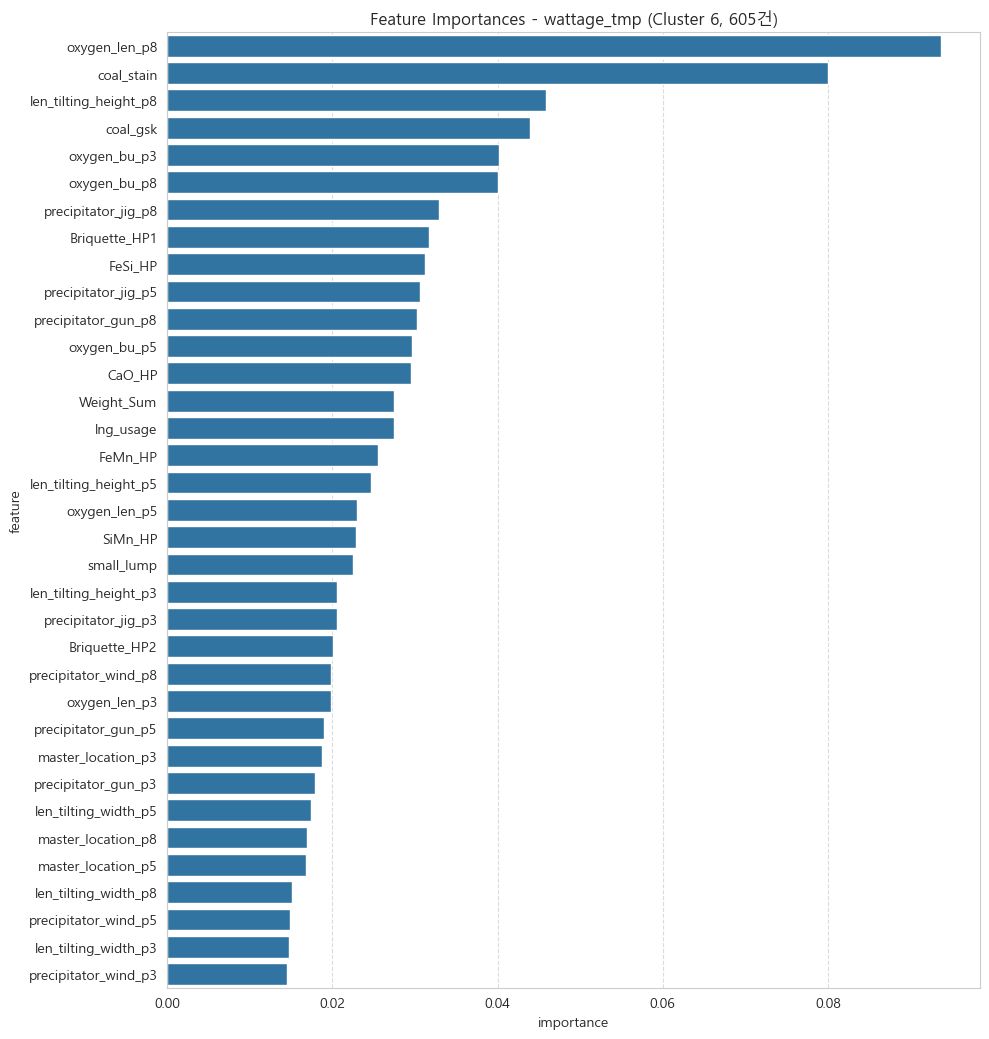


[Cluster 6 변수 중요도 순위]
                  feature  importance
20          oxygen_len_p8    0.093729
33             coal_stain    0.080062
25  len_tilting_height_p8    0.045859
32               coal_gsk    0.043886
27           oxygen_bu_p3    0.040188
29           oxygen_bu_p8    0.040063
8     precipitator_jig_p8    0.032963
4           Briquette_HP1    0.031682
2                 FeSi_HP    0.031237
7     precipitator_jig_p5    0.030658
11    precipitator_gun_p8    0.030267
28           oxygen_bu_p5    0.029640
0                  CaO_HP    0.029524
30             Weight_Sum    0.027493
31              lng_usage    0.027416
1                 FeMn_HP    0.025562
23  len_tilting_height_p5    0.024723
19          oxygen_len_p5    0.022989
3                 SiMn_HP    0.022899
34             small_lump    0.022534
21  len_tilting_height_p3    0.020585
6     precipitator_jig_p3    0.020495
5           Briquette_HP2    0.020057
14   precipitator_wind_p8    0.019837
18          oxygen_len_p3  

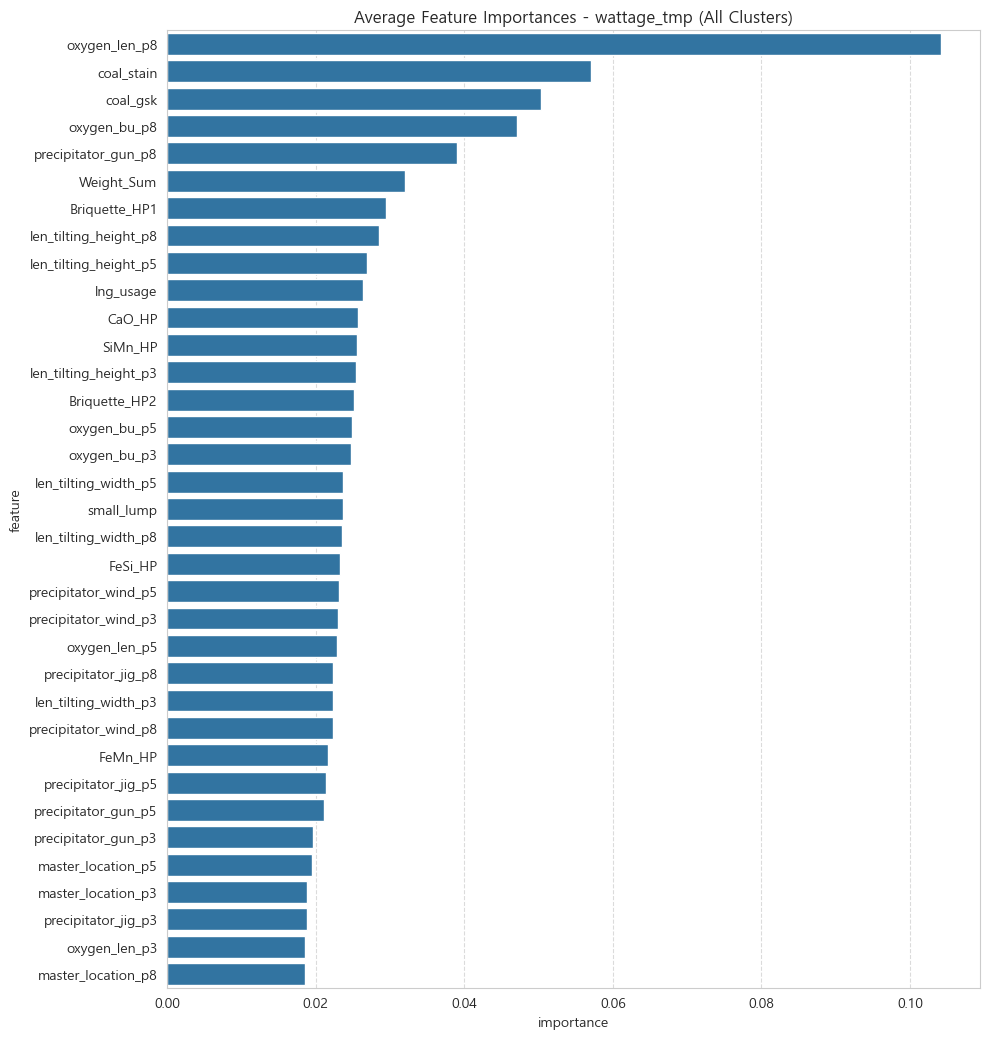


[전체 평균 변수 중요도 순위]
                  feature  importance
0           oxygen_len_p8    0.104208
1              coal_stain    0.057054
2                coal_gsk    0.050304
3            oxygen_bu_p8    0.047042
4     precipitator_gun_p8    0.038980
5              Weight_Sum    0.032051
6           Briquette_HP1    0.029411
7   len_tilting_height_p8    0.028502
8   len_tilting_height_p5    0.026867
9               lng_usage    0.026318
10                 CaO_HP    0.025638
11                SiMn_HP    0.025600
12  len_tilting_height_p3    0.025413
13          Briquette_HP2    0.025199
14           oxygen_bu_p5    0.024906
15           oxygen_bu_p3    0.024702
16   len_tilting_width_p5    0.023667
17             small_lump    0.023666
18   len_tilting_width_p8    0.023556
19                FeSi_HP    0.023284
20   precipitator_wind_p5    0.023147
21   precipitator_wind_p3    0.022969
22          oxygen_len_p5    0.022910
23    precipitator_jig_p8    0.022310
24   len_tilting_width_p3    0.

In [12]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 클러스터별 변수 중요도 추출 및 시각화
for c, model_c in models.items():
    importances = model_c.feature_importances_
    feature_df = pd.DataFrame({
        'feature': X_train.columns,
        'importance': importances
    }).sort_values(by='importance', ascending=False)

    plt.figure(figsize=(10, len(X_train.columns) * 0.3))
    sns.barplot(x='importance', y='feature', data=feature_df)
    plt.title(f'Feature Importances - {TARGETS[0]} (Cluster {c}, {(train_clusters == c).sum()}건)')
    plt.grid(axis='x', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print(f"\n[Cluster {c} 변수 중요도 순위]")
    print(feature_df)
    print()

# 전체 평균 중요도
avg_importances = np.mean([m.feature_importances_ for m in models.values()], axis=0)
feature_importance_df = pd.DataFrame({
    'feature': X_train.columns,
    'importance': avg_importances
}).sort_values(by='importance', ascending=False).reset_index(drop=True)

plt.figure(figsize=(10, len(X_train.columns) * 0.3))
sns.barplot(x='importance', y='feature', data=feature_importance_df)
plt.title(f'Average Feature Importances - {TARGETS[0]} (All Clusters)')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print(f"\n[전체 평균 변수 중요도 순위]")
print(feature_importance_df)

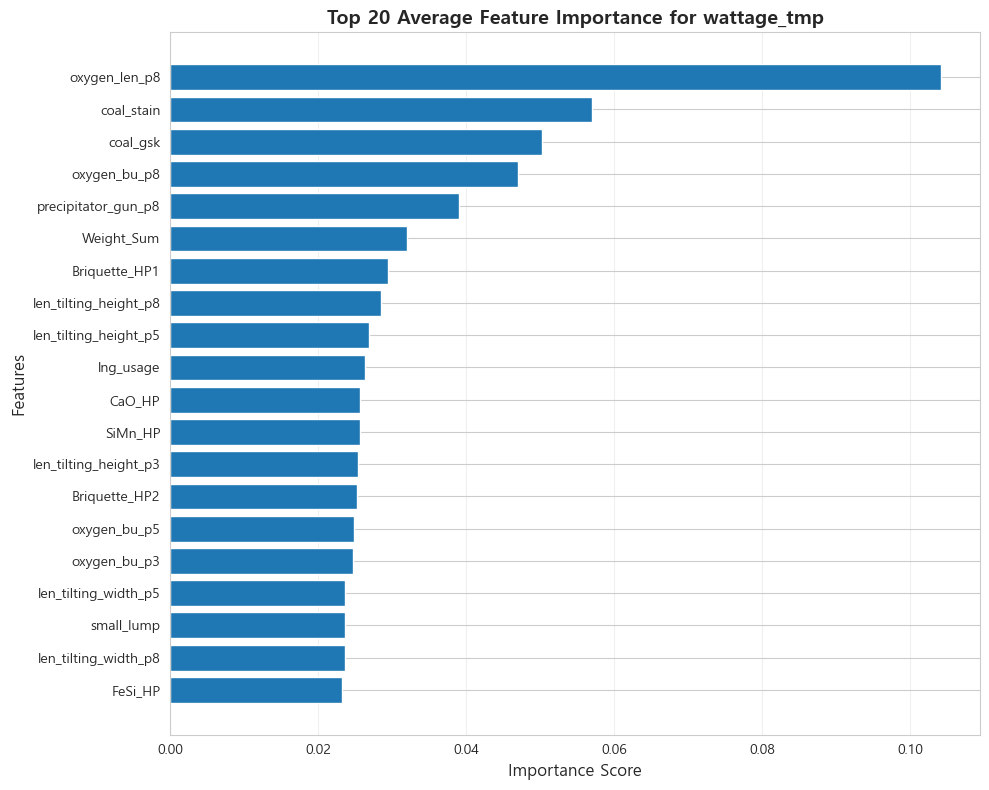

In [13]:
# Feature Importance Top 20 시각화 (평균 기준)
top_n = 20

plt.figure(figsize=(10, 8))
top_features = feature_importance_df.head(top_n)

plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title(f'Top {top_n} Average Feature Importance for {TARGETS[0]}', 
         fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

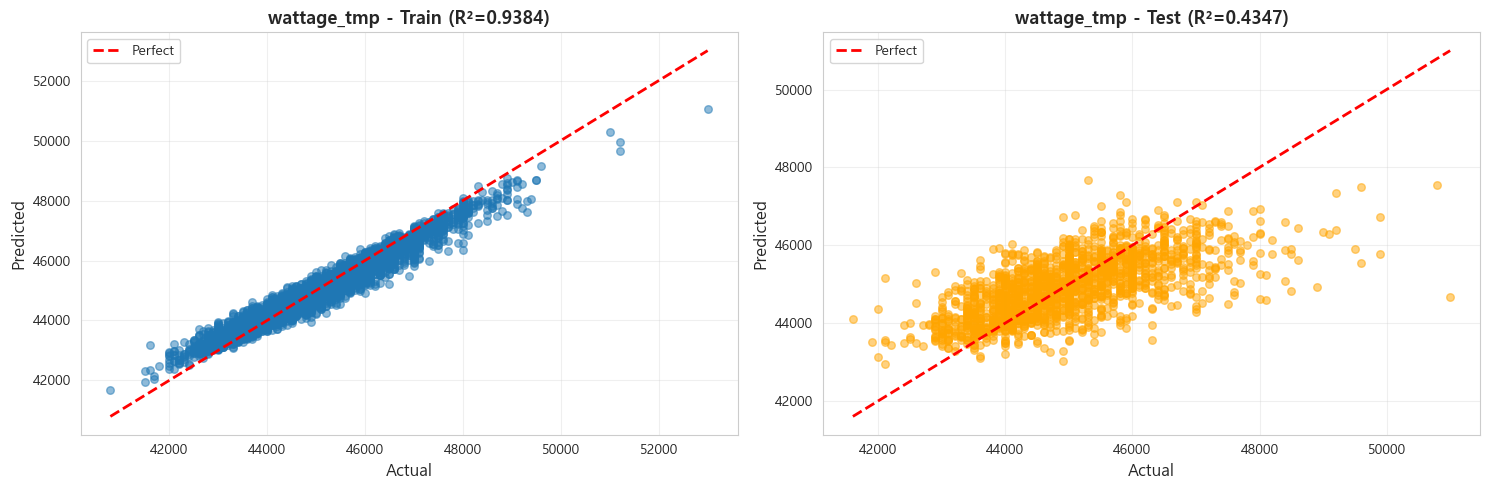

In [14]:
# 예측 vs 실제 시각화
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))

# 타겟이 1개일 때 axes 차원 조정
if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    
    # Train set
    axes[idx, 0].scatter(y_tr, y_pred_tr, alpha=0.5, s=30)
    axes[idx, 0].plot([y_tr.min(), y_tr.max()],
                      [y_tr.min(), y_tr.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 0].set_xlabel('Actual', fontsize=12)
    axes[idx, 0].set_ylabel('Predicted', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Train (R²={train_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].legend()
    axes[idx, 0].grid(True, alpha=0.3)
    
    # Test set
    axes[idx, 1].scatter(y_te, y_pred_te, alpha=0.5, s=30, color='orange')
    axes[idx, 1].plot([y_te.min(), y_te.max()],
                      [y_te.min(), y_te.max()], 'r--', lw=2, label='Perfect')
    axes[idx, 1].set_xlabel('Actual', fontsize=12)
    axes[idx, 1].set_ylabel('Predicted', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Test (R²={test_r2:.4f})', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].legend()
    axes[idx, 1].grid(True, alpha=0.3)

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.show()

In [15]:
# K-Fold Cross Validation (GMM split included)
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

FAST_MODE = globals().get("FAST_MODE", True)
KFOLD_SPLITS = 3 if FAST_MODE else 5
CV_SAMPLE = 3000 if FAST_MODE else None

print("Running CV with GMM split...")

if CV_SAMPLE is not None and len(X) > CV_SAMPLE:
    rng = np.random.RandomState(42)
    idx = rng.choice(len(X), size=CV_SAMPLE, replace=False)
    X_cv_base = X.iloc[idx]
    y_cv_base = y.iloc[idx]
else:
    X_cv_base = X
    y_cv_base = y

kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=42)
cv_r2_scores = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_cv_base), 1):
    X_cv_train, X_cv_val = X_cv_base.iloc[train_idx], X_cv_base.iloc[val_idx]
    y_cv_train = y_cv_base.values.ravel()[train_idx]
    y_cv_val = y_cv_base.values.ravel()[val_idx]

    sc = StandardScaler()
    X_cv_train_scaled = sc.fit_transform(X_cv_train.values)
    X_cv_val_scaled = sc.transform(X_cv_val.values)

    gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    cv_train_clusters = gmm_cv.fit_predict(X_cv_train_scaled)
    cv_val_clusters = gmm_cv.predict(X_cv_val_scaled)

    global_cv_model = xgb.XGBRegressor(**params)
    global_cv_model.fit(X_cv_train, y_cv_train, verbose=False)
    y_cv_pred = global_cv_model.predict(X_cv_val)

    min_cluster_size_cv = max(40, int(0.03 * len(X_cv_train)))

    for c in range(best_n):
        train_mask = cv_train_clusters == c
        val_mask = cv_val_clusters == c
        if train_mask.sum() >= min_cluster_size_cv and val_mask.sum() > 0:
            m = xgb.XGBRegressor(**params)
            m.fit(X_cv_train.iloc[train_mask], y_cv_train[train_mask], verbose=False)
            y_cv_pred[val_mask] = m.predict(X_cv_val.iloc[val_mask])

    fold_r2 = r2_score(y_cv_val, y_cv_pred)
    fold_rmse = np.sqrt(mean_squared_error(y_cv_val, y_cv_pred))
    cv_r2_scores.append(fold_r2)
    print(f"  Fold {fold}: R2 = {fold_r2:.4f}, RMSE = {fold_rmse:.4f}")

print("=" * 50)
print(f"{KFOLD_SPLITS}-Fold CV mean R2: {np.mean(cv_r2_scores):.4f} (+/-{np.std(cv_r2_scores):.4f})")
print("=" * 50)



교차 검증 수행 중 (GMM 분할 학습)...
  Fold 1: R² = 0.4412, RMSE = 881.4305
  Fold 2: R² = 0.4405, RMSE = 910.8133
  Fold 3: R² = 0.5046, RMSE = 791.1482
  Fold 4: R² = 0.4847, RMSE = 860.0584
  Fold 5: R² = 0.5032, RMSE = 809.4638
  Fold 6: R² = 0.5003, RMSE = 827.2074
  Fold 7: R² = 0.4339, RMSE = 856.2348
  Fold 8: R² = 0.4805, RMSE = 882.5925
  Fold 9: R² = 0.5015, RMSE = 841.7340
  Fold 10: R² = 0.4249, RMSE = 891.6940
5-Fold CV 평균 R²: 0.4715 (±0.0309)



【wattage_tmp 잔차 통계】
  평균: 50.1603
  표준편차: 899.7618
  최대값: 6329.5312
  최소값: -3045.2188

💾 저장 완료: residuals_wattage_tmp.png


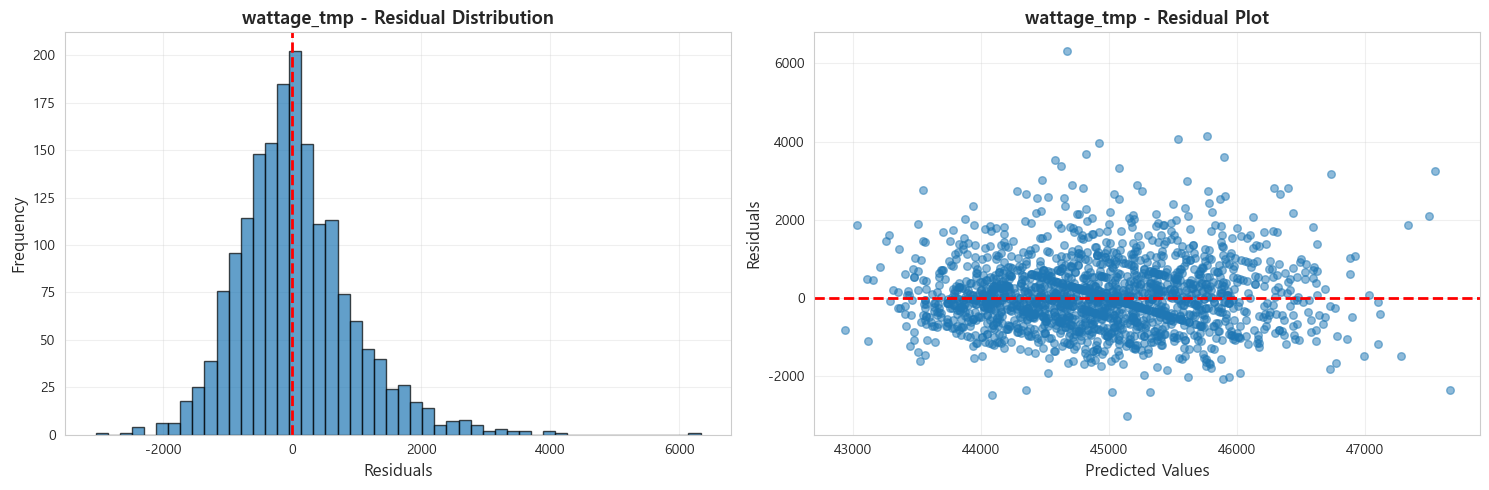

In [16]:
# 잔차 분석
n_targets = len(targets_to_evaluate)
fig, axes = plt.subplots(n_targets, 2, figsize=(15, 5*n_targets))
# 각 타겟별로 2개 그래프 (분포 히스토그램, 잔차 플롯)

if n_targets == 1:
    axes = axes.reshape(1, -1)

for idx, (target_name, y_tr, y_te, y_pred_tr, y_pred_te) in enumerate(targets_to_evaluate):
    residuals_test = y_te - y_pred_te  # 잔차 = 실제값 - 예측값
    # 양수: 과소예측 (실제가 더 큼)
    # 음수: 과대예측 (예측이 더 큼)
    
    # ===== 왼쪽: 잔차 분포 히스토그램 =====
    axes[idx, 0].hist(residuals_test, bins=50, edgecolor='black', alpha=0.7)
    # hist: 히스토그램 (막대 그래프)
    #   - bins=50: 50개 구간으로 나눔
    #   - edgecolor='black': 막대 테두리 색
    #   - alpha=0.7: 투명도 70%
    
    axes[idx, 0].axvline(x=0, color='red', linestyle='--', linewidth=2)
    # axvline: 수직선 그리기
    #   - x=0 위치에 빨간 점선
    #   - 이상적으로는 이 선을 중심으로 대칭이어야 함
    
    axes[idx, 0].set_xlabel('Residuals', fontsize=12)
    axes[idx, 0].set_ylabel('Frequency', fontsize=12)
    axes[idx, 0].set_title(f'{target_name} - Residual Distribution', 
                          fontsize=13, fontweight='bold')
    axes[idx, 0].grid(True, alpha=0.3)
    
    # ===== 오른쪽: 잔차 vs 예측값 산점도 =====
    axes[idx, 1].scatter(y_pred_te, residuals_test, alpha=0.5, s=30)
    # x축: 예측값
    # y축: 잔차
    # 패턴 없이 무작위로 흩어져야 좋은 모델
    
    axes[idx, 1].axhline(y=0, color='red', linestyle='--', linewidth=2)
    # axhline: 수평선 그리기
    #   - y=0 위치 (잔차 0)
    #   - 점들이 이 선 주위에 랜덤하게 분포해야 함
    
    axes[idx, 1].set_xlabel('Predicted Values', fontsize=12)
    axes[idx, 1].set_ylabel('Residuals', fontsize=12)
    axes[idx, 1].set_title(f'{target_name} - Residual Plot', 
                          fontsize=13, fontweight='bold')
    axes[idx, 1].grid(True, alpha=0.3)
    
    # 통계 정보 출력
    print(f"\n【{target_name} 잔차 통계】")
    print(f"  평균: {residuals_test.mean():.4f}")
    # 평균이 0에 가까워야 함 (편향 없음)
    
    print(f"  표준편차: {residuals_test.std():.4f}")
    # 오차의 퍼진 정도
    
    print(f"  최대값: {residuals_test.max():.4f}")
    # 가장 크게 과소예측한 경우
    
    print(f"  최소값: {residuals_test.min():.4f}")
    # 가장 크게 과대예측한 경우

targets_str = '_'.join(TARGETS)
plt.tight_layout()
plt.savefig(f'residuals_{targets_str}.png', dpi=300, bbox_inches='tight')
print(f"\n💾 저장 완료: residuals_{targets_str}.png")
plt.show()

In [17]:
from datetime import datetime

print("=" * 80)
print("XGBoost 모델 학습 결과 요약 (GMM 분할 학습)")
print("=" * 80)

print(f"\n【실험 정보】")
print(f"  실험 일시: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"  타겟 변수: {', '.join(TARGETS)}")
print(f"  GMM 클러스터 수: {best_n}")
print(f"  총 데이터 개수: {len(df_model)}")
print(f"  Train 데이터: {len(X_train)} ({len(X_train)/len(df_model)*100:.1f}%)")
print(f"  Test 데이터: {len(X_test)} ({len(X_test)/len(df_model)*100:.1f}%)")

print(f"\n【클러스터 분포】")
for c in range(best_n):
    print(f"  Cluster {c}: Train {(train_clusters == c).sum()}건, Test {(test_clusters == c).sum()}건")

print(f"\n【데이터 전처리】")
print(f"  결측치 → 0 (미투입 처리)")

print(f"\n【특성 정보】")
print(f"  총 특성 개수: {len(SELECTED_FEATURES)}")

print(f"\n【하이퍼파라미터】")
for key, value in params.items():
    print(f"  {key:25s}: {value}")

print(f"\n【모델 성능】")
for target_name, y_tr, y_te, y_pred_tr, y_pred_te in targets_to_evaluate:
    train_rmse = np.sqrt(mean_squared_error(y_tr, y_pred_tr))
    test_rmse = np.sqrt(mean_squared_error(y_te, y_pred_te))
    train_r2 = r2_score(y_tr, y_pred_tr)
    test_r2 = r2_score(y_te, y_pred_te)
    train_mae = mean_absolute_error(y_tr, y_pred_tr)
    test_mae = mean_absolute_error(y_te, y_pred_te)
    
    print(f"\n  ▶ {target_name}")
    print(f"    Train - RMSE: {train_rmse:>10.4f}  |  R²: {train_r2:>6.4f}  |  MAE: {train_mae:>10.4f}")
    print(f"    Test  - RMSE: {test_rmse:>10.4f}  |  R²: {test_r2:>6.4f}  |  MAE: {test_mae:>10.4f}")
    
    overfitting = train_r2 - test_r2
    if overfitting > 0.1:
        print(f"    ⚠️  과적합 감지 (R² 차이: {overfitting:.4f})")
    else:
        print(f"    ✅  과적합 없음 (R² 차이: {overfitting:.4f})")
    
    print(f"    타겟 범위: {y_te.min():.2f} ~ {y_te.max():.2f}")
    print(f"    타겟 평균: {y_te.mean():.2f} (표준편차: {y_te.std():.2f})")

print(f"\n【주요 특성 (Top 10, 평균 중요도)】")
for idx, row in feature_importance_df.head(10).iterrows():
    print(f"  {idx+1:2d}. {row['feature']:25s}  중요도: {row['importance']:.6f}")

print("\n" + "=" * 80)

XGBoost 모델 학습 결과 요약 (GMM 분할 학습)

【실험 정보】
  실험 일시: 2026-02-04 08:51:16
  타겟 변수: wattage_tmp
  GMM 클러스터 수: 7
  총 데이터 개수: 8950
  Train 데이터: 7160 (80.0%)
  Test 데이터: 1790 (20.0%)

【클러스터 분포】
  Cluster 0: Train 1159건, Test 278건
  Cluster 1: Train 1392건, Test 363건
  Cluster 2: Train 1522건, Test 407건
  Cluster 3: Train 1999건, Test 497건
  Cluster 4: Train 130건, Test 16건
  Cluster 5: Train 353건, Test 63건
  Cluster 6: Train 605건, Test 166건

【데이터 전처리】
  결측치 → 0 (미투입 처리)

【특성 정보】
  총 특성 개수: 35

【하이퍼파라미터】
  objective                : reg:squarederror
  random_state             : 42
  tree_method              : hist
  device                   : cuda
  sampling_method          : gradient_based
  max_bin                  : 256
  max_depth                : 6
  learning_rate            : 0.01223826357909319
  n_estimators             : 800
  subsample                : 0.7
  colsample_bytree         : 0.6
  min_child_weight         : 6
  gamma                    : 5.0
  reg_alpha                : 1.0
  re

In [18]:
class ExperimentLogger:
    """실험 결과를 자동으로 기록하는 클래스"""
    
    def __init__(self, log_file='experiment_log_xgb.json'):
        self.log_file = log_file
        self.experiments = []
        self.load_existing_logs()
    
    def load_existing_logs(self):
        """기존 로그 불러오기"""
        try:
            with open(self.log_file, 'r', encoding='utf-8') as f:
                self.experiments = json.load(f)
            print(f"✅ 기존 로그 {len(self.experiments)}개 불러옴: {self.log_file}")
        except FileNotFoundError:
            print(f"📝 새로운 로그 파일 생성: {self.log_file}")
            self.experiments = []
    
    def log_experiment(self, target, features, params, results, feature_importance=None):
        """실험 결과 기록"""
        experiment = {
            'experiment_id': len(self.experiments) + 1,
            'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
            'target': target,
            'n_features': len(features),
            'features': features,
            'params': params,
            'results': results,
            'feature_importance_top10': feature_importance
        }
        self.experiments.append(experiment)
        self.save()
        return experiment['experiment_id']
    
    def save(self):
        """로그 파일 저장"""
        with open(self.log_file, 'w', encoding='utf-8') as f:
            json.dump(self.experiments, f, ensure_ascii=False, indent=2)
    
    def get_best_experiment(self, target, metric='test_r2'):
        """특정 타겟의 최고 성능 실험 찾기"""
        target_exps = [e for e in self.experiments if e['target'] == target]
        if not target_exps:
            return None
        return max(target_exps, key=lambda x: x['results'][metric])
    
    def print_summary(self):
        """전체 실험 요약"""
        if len(self.experiments) == 0:
            print("아직 실험 기록이 없습니다.")
            return
        
        print(f"\n{'='*80}")
        print(f"📊 실험 기록 요약")
        print(f"{'='*80}")
        print(f"총 실험 횟수: {len(self.experiments)}")
        print(f"로그 파일: {self.log_file}")
        print(f"{'='*80}\n")
        
        # 타겟별 최고 성능
        targets = set(e['target'] for e in self.experiments)
        for target in sorted(targets):
            best = self.get_best_experiment(target)
            if best:
                print(f"[{target}] 최고 성능 (실험 #{best['experiment_id']})")
                print(f"  Test R²:    {best['results']['test_r2']:.4f}")
                print(f"  Test MAPE:  {best['results'].get('test_mape', 0):.2f}%")  # ✨ 추가
                print(f"  Test SMAPE: {best['results'].get('test_smape', 0):.2f}%") # ✨ 추가
                print(f"  Test RMSE:  {best['results']['test_rmse']:.4f}")
                print(f"  CV R²:      {best['results']['cv_r2']:.4f}")
                print(f"  실험 시각:  {best['timestamp']}")
                print(f"  특성 개수:  {best['n_features']}")
                print(f"  주요 파라미터:")
                print(f"    - max_depth: {best['params']['max_depth']}")
                print(f"    - learning_rate: {best['params']['learning_rate']:.4f}")
                print(f"    - n_estimators: {best['params']['n_estimators']}")
                print(f"  Top 5 특성: {', '.join(best['feature_importance_top10'][:5])}")
                print()
    
    def get_experiments_df(self):
        """실험 결과를 DataFrame으로 변환"""
        if len(self.experiments) == 0:
            return pd.DataFrame()
        
        records = []
        for exp in self.experiments:
            record = {
                'exp_id': exp['experiment_id'],
                'timestamp': exp['timestamp'],
                'target': exp['target'],
                'n_features': exp['n_features'],
                'test_r2': exp['results']['test_r2'],
                'test_mape': exp['results'].get('test_mape'),   # ✨ 추가
                'test_smape': exp['results'].get('test_smape'), # ✨ 추가
                'test_rmse': exp['results']['test_rmse'],
                'cv_r2': exp['results']['cv_r2'],
                'max_depth': exp['params']['max_depth'],
                'learning_rate': exp['params']['learning_rate'],
                'n_estimators': exp['params']['n_estimators'],
            }
            records.append(record)
        
        return pd.DataFrame(records)

# 로거 초기화
logger = ExperimentLogger('experiment_log_xgb.json')
logger.print_summary()

✅ 기존 로그 1개 불러옴: experiment_log_xgb.json

📊 실험 기록 요약
총 실험 횟수: 1
로그 파일: experiment_log_xgb.json

[wattage_tmp] 최고 성능 (실험 #1)
  Test R²:    0.4395
  Test MAPE:  1.46%
  Test SMAPE: 1.47%
  Test RMSE:  897.2811
  CV R²:      0.4720
  실험 시각:  2026-02-03 22:16:18
  특성 개수:  35
  주요 파라미터:
    - max_depth: 6
    - learning_rate: 0.0111
    - n_estimators: 950
  Top 5 특성: oxygen_len_p8, coal_stain, coal_gsk, oxygen_bu_p8, precipitator_gun_p8



In [19]:
def objective(trial, target_name, X_data, y_data):
    """GMM split learning + K-Fold CV objective with stronger regularization"""

    FAST_MODE = globals().get("FAST_MODE", True)
    FORCE_GPU = globals().get("FORCE_GPU", True)
    KFOLD_SPLITS = 3 if FAST_MODE else 5
    device_type = "cuda" if FORCE_GPU else "cpu"

    params = {
        "objective": "reg:squarederror",
        "max_depth": trial.suggest_int("max_depth", 3, 4),
        "learning_rate": trial.suggest_float("learning_rate", 0.02, 0.08, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 150, 350, step=50),
        "subsample": trial.suggest_float("subsample", 0.65, 0.90),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.55, 0.85),
        "min_child_weight": trial.suggest_int("min_child_weight", 8, 30),
        "gamma": trial.suggest_float("gamma", 5, 15),
        "reg_alpha": trial.suggest_float("reg_alpha", 1, 8),
        "reg_lambda": trial.suggest_float("reg_lambda", 8, 35),
        "random_state": 42,
        "tree_method": "hist",
        "device": device_type,
        "max_bin": 128,
        "sampling_method": "gradient_based" if device_type == "cuda" else "uniform",
        "n_jobs": 1,
    }

    kf = KFold(n_splits=KFOLD_SPLITS, shuffle=True, random_state=42)
    fold_r2s = []

    for fold_idx, (train_idx, val_idx) in enumerate(kf.split(X_data), 1):
        X_tr, X_val = X_data.iloc[train_idx], X_data.iloc[val_idx]
        y_tr, y_val = y_data.values[train_idx], y_data.values[val_idx]

        sc = StandardScaler()
        X_tr_scaled = sc.fit_transform(X_tr.values)
        X_val_scaled = sc.transform(X_val.values)

        gmm_cv = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
        tr_clusters = gmm_cv.fit_predict(X_tr_scaled)
        val_clusters = gmm_cv.predict(X_val_scaled)

        global_fold_model = xgb.XGBRegressor(**params)
        global_fold_model.fit(X_tr, y_tr, verbose=False)
        y_pred = global_fold_model.predict(X_val)

        min_cluster_size = max(40, int(0.03 * len(X_tr)))
        for c in range(best_n):
            tr_mask = tr_clusters == c
            val_mask = val_clusters == c
            if tr_mask.sum() >= min_cluster_size and val_mask.sum() > 0:
                m = xgb.XGBRegressor(**params)
                m.fit(X_tr.iloc[tr_mask], y_tr[tr_mask], verbose=False)
                y_pred[val_mask] = m.predict(X_val.iloc[val_mask])

        fold_r2 = r2_score(y_val, y_pred)
        fold_r2s.append(fold_r2)

        trial.report(float(np.mean(fold_r2s)), step=fold_idx)
        if trial.should_prune():
            raise optuna.TrialPruned()

    mean_r2 = float(np.mean(fold_r2s))
    std_r2 = float(np.std(fold_r2s))
    return mean_r2 - 0.05 * std_r2

print("Optuna objective is ready (regularized)")



Optuna 목적 함수 정의 완료 (GMM 분할 학습)


In [20]:
def run_optimization(target_name, n_trials=100, timeout=None):
    """GMM split-based hyperparameter optimization (regularized)"""

    print(f"\n{'='*80}")
    print(f"[{target_name}] optimization start (GMM {best_n} clusters)")
    print(f"{'='*80}")
    print(f"Trials: {n_trials}")
    if timeout:
        print(f"Timeout: {timeout} sec")
    print(f"{'='*80}\n")

    FAST_MODE = globals().get("FAST_MODE", True)
    FORCE_GPU = globals().get("FORCE_GPU", True)
    OPTUNA_N_JOBS = 1
    OPTUNA_SAMPLE = 3500 if FAST_MODE else None

    targets_optuna = [target_name]
    df_model_optuna = df_processed.dropna(subset=targets_optuna)

    X_data = df_model_optuna[SELECTED_FEATURES]
    y_data = df_model_optuna[target_name]

    if OPTUNA_SAMPLE is not None and len(X_data) > OPTUNA_SAMPLE:
        rng = np.random.RandomState(42)
        sampled_idx = rng.choice(len(X_data), size=OPTUNA_SAMPLE, replace=False)
        X_data = X_data.iloc[sampled_idx]
        y_data = y_data.iloc[sampled_idx]
        print(f"Optuna sampled rows: {len(X_data)}")

    X_tr, X_te, y_tr, y_te = train_test_split(
        X_data, y_data, test_size=0.2, random_state=42
    )

    print(f"Total rows: {len(X_data)}")
    print(f"Train rows: {len(X_tr)} | Test rows: {len(X_te)}")
    print(f"Feature count: {len(SELECTED_FEATURES)}")
    print(f"FORCE_GPU: {FORCE_GPU}\n")

    if FORCE_GPU:
        try:
            probe_rows = min(512, len(X_tr))
            probe = xgb.XGBRegressor(
                objective="reg:squarederror",
                tree_method="hist",
                device="cuda",
                n_estimators=10,
                max_depth=3,
                max_bin=128,
                n_jobs=1,
                verbosity=0,
            )
            probe.fit(X_tr.iloc[:probe_rows], y_tr.values[:probe_rows], verbose=False)
            cfg = probe.get_booster().save_config()
            if "grow_gpu_hist" not in cfg:
                raise RuntimeError("GPU updater(grow_gpu_hist) not found")
            print("GPU check passed: grow_gpu_hist is active")
        except Exception as e:
            raise RuntimeError("FORCE_GPU=True but CUDA execution failed. Check GPU/driver/XGBoost install.") from e

    study = optuna.create_study(
        direction="maximize",
        sampler=optuna.samplers.TPESampler(seed=42),
        pruner=optuna.pruners.MedianPruner(n_startup_trials=5, n_warmup_steps=1),
        study_name=f"{target_name}_gmm_opt_{datetime.now().strftime('%Y%m%d_%H%M%S')}",
    )

    study.optimize(
        lambda trial: objective(trial, target_name, X_tr, y_tr),
        n_trials=n_trials,
        timeout=timeout,
        n_jobs=OPTUNA_N_JOBS,
        show_progress_bar=True,
    )

    print(f"\n{'='*80}")
    print(f"Optimization done! Best CV score: {study.best_value:.4f}")
    print(f"{'='*80}")
    print("\nBest params:")
    for key, value in study.best_params.items():
        if isinstance(value, float):
            print(f"  {key:25s}: {value:.6f}")
        else:
            print(f"  {key:25s}: {value}")

    print(f"\n{'='*80}")
    print(f"Training final model with best params (GMM {best_n})...")
    print(f"{'='*80}\n")

    opt_params = {
        "objective": "reg:squarederror",
        "random_state": 42,
        "tree_method": "hist",
        "device": "cuda" if FORCE_GPU else "cpu",
        "max_bin": 128,
        "sampling_method": "gradient_based" if FORCE_GPU else "uniform",
        "n_jobs": 1,
        **study.best_params,
    }

    sc = StandardScaler()
    X_tr_scaled = sc.fit_transform(X_tr.values)
    X_te_scaled = sc.transform(X_te.values)

    gmm_opt = GaussianMixture(n_components=best_n, random_state=42, **GMM_KWARGS)
    tr_clusters = gmm_opt.fit_predict(X_tr_scaled)
    te_clusters = gmm_opt.predict(X_te_scaled)

    global_opt_model = xgb.XGBRegressor(**opt_params)
    global_opt_model.fit(X_tr, y_tr.values, verbose=False)

    y_pred_tr = global_opt_model.predict(X_tr)
    y_pred_te = global_opt_model.predict(X_te)

    min_cluster_size = max(80, int(0.03 * len(X_tr)))
    opt_models = {}

    for c in range(best_n):
        tr_mask = tr_clusters == c
        te_mask = te_clusters == c

        if tr_mask.sum() < min_cluster_size:
            continue

        m = xgb.XGBRegressor(**opt_params)
        m.fit(X_tr.iloc[tr_mask], y_tr.values[tr_mask], verbose=False)
        opt_models[c] = m

        y_pred_tr[tr_mask] = m.predict(X_tr.iloc[tr_mask])
        if te_mask.sum() > 0:
            y_pred_te[te_mask] = m.predict(X_te.iloc[te_mask])

    def get_mape(y_true, y_pred):
        return np.mean(np.abs((y_true - y_pred) / (y_true + 1e-9))) * 100

    def get_smape(y_true, y_pred):
        return 100 / len(y_true) * np.sum(
            2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-9)
        )

    results = {
        "train_rmse": float(np.sqrt(mean_squared_error(y_tr, y_pred_tr))),
        "test_rmse": float(np.sqrt(mean_squared_error(y_te, y_pred_te))),
        "train_r2": float(r2_score(y_tr, y_pred_tr)),
        "test_r2": float(r2_score(y_te, y_pred_te)),
        "test_mae": float(mean_absolute_error(y_te, y_pred_te)),
        "test_mape": float(get_mape(y_te.values, y_pred_te)),
        "test_smape": float(get_smape(y_te.values, y_pred_te)),
        "cv_r2": float(study.best_value),
        "n_trials": len(study.trials),
        "gmm_n_components": best_n,
    }

    print("Final metrics:")
    print(f"  Train R2:   {results['train_r2']:.4f}  |  RMSE: {results['train_rmse']:.4f}")
    print(f"  Test R2:    {results['test_r2']:.4f}  |  RMSE: {results['test_rmse']:.4f}")
    print(f"  Test MAE:   {results['test_mae']:.4f}")
    print(f"  Test MAPE:  {results['test_mape']:.2f}%")
    print(f"  Test SMAPE: {results['test_smape']:.2f}%")
    print(f"  CV score:   {results['cv_r2']:.4f}")

    overfitting = results['train_r2'] - results['test_r2']
    if overfitting > 0.1:
        print(f"  Overfitting detected (R2 gap: {overfitting:.4f})")
    else:
        print(f"  Overfitting under control (R2 gap: {overfitting:.4f})")

    if opt_models:
        avg_imp = np.mean([m.feature_importances_ for m in opt_models.values()], axis=0)
    else:
        avg_imp = global_opt_model.feature_importances_

    feature_importance = pd.DataFrame(
        {"feature": SELECTED_FEATURES, "importance": avg_imp}
    ).sort_values("importance", ascending=False)

    print("\nTop 10 features:")
    for rank, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
        print(f"  {rank:2d}. {row['feature']:25s}  {row['importance']:.6f}")

    top10_features = feature_importance.head(10)["feature"].tolist()

    exp_id = logger.log_experiment(
        target=target_name,
        features=SELECTED_FEATURES,
        params=opt_params,
        results=results,
        feature_importance=top10_features,
    )

    print(f"\nExperiment saved (id: #{exp_id})")

    return study, opt_models, results

print("Optimization runner is ready")



최적화 함수 정의 완료 (GMM 분할 학습)


In [ ]:
# ===== Optimization run config =====
FAST_MODE = False
FORCE_GPU = True
TARGET_OPTUNA = 'tot_result1'
N_TRIALS = 40
TIMEOUT = 3600
# ===================================

print(
    f"FAST_MODE={FAST_MODE}, FORCE_GPU={FORCE_GPU}, "
    f"TARGET={TARGET_OPTUNA}, N_TRIALS={N_TRIALS}, TIMEOUT={TIMEOUT}"
)

study, model_optuna, results_optuna = run_optimization(
    TARGET_OPTUNA,
    n_trials=N_TRIALS,
    timeout=TIMEOUT,
)



[I 2026-02-04 08:51:16,815] A new study created in memory with name: wattage_tmp_gmm_opt_20260204_085116



[wattage_tmp] 하이퍼파라미터 최적화 시작 (GMM 7그룹)
시도 횟수: 200

전체 데이터: 8950
학습용: 7160 | 테스트용: 1790
특성 개수: 35



  0%|          | 0/200 [00:00<?, ?it/s]

[I 2026-02-04 08:52:46,918] Trial 2 finished with value: 0.4489352247210762 and parameters: {'max_depth': 3, 'learning_rate': 0.028369983113137525, 'n_estimators': 300, 'subsample': 0.8171314512256609, 'colsample_bytree': 0.876193462108134, 'min_child_weight': 1, 'gamma': 2.8356188397654707, 'reg_alpha': 0.3009241934633782, 'reg_lambda': 5.228647374443281}. Best is trial 2 with value: 0.4489352247210762.
[I 2026-02-04 08:53:02,078] Trial 3 finished with value: 0.4338112271930468 and parameters: {'max_depth': 3, 'learning_rate': 0.013779750124479562, 'n_estimators': 400, 'subsample': 0.8441438953071311, 'colsample_bytree': 0.6155540926104279, 'min_child_weight': 6, 'gamma': 0.901928163675419, 'reg_alpha': 0.1910592382653007, 'reg_lambda': 6.532522845701775}. Best is trial 2 with value: 0.4489352247210762.
[I 2026-02-04 08:53:46,505] Trial 1 finished with value: 0.4411513102022388 and parameters: {'max_depth': 4, 'learning_rate': 0.07633328230619521, 'n_estimators': 550, 'subsample': 0.7

In [22]:
import joblib
import json

# Save GMM + cluster models + global fallback model
save_data = {
    "global_model": global_model,
    "models": models,
    "gmm": gmm,
    "scaler": scaler,
    "best_n": best_n,
    "min_cluster_size": MIN_CLUSTER_SIZE,
    "params": params,
    "feature_names": SELECTED_FEATURES,
    "targets": TARGETS,
}

model_path = f"xgb_gmm_{TARGETS[0]}.pkl"
joblib.dump(save_data, model_path)
print(f"Saved GMM split model: '{model_path}'")

feature_names_path = f"feature_names_{TARGETS[0]}.json"
with open(feature_names_path, "w", encoding="utf-8") as f:
    json.dump(SELECTED_FEATURES, f, ensure_ascii=False, indent=4)
print(f"Saved feature list: '{feature_names_path}'")



GMM 분할 모델 저장 완료: 'xgb_gmm_wattage_tmp.pkl'
특성 이름 목록 저장 완료: 'feature_names_wattage_tmp.json'
